## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

Much of this code is from Intel's course at: https://software.intel.com/content/dam/develop/public/us/en/downloads/intel-dl101-class6.zip, but I added some tweaks of my own ;)

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape

(32, 32, 3)

Notice that this time the pictures have color (RGB color with 3 channels).

[8]


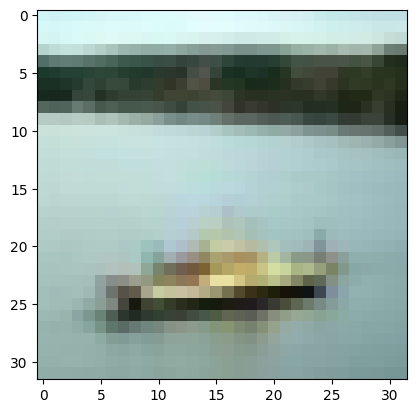

In [ ]:
## Let's look at one of the images

print(y_train[442])
plt.imshow(x_train[442]);

In [ ]:
#On my local machine I had to write:
#from keras.utils.np_utils import to_categorical'''
from keras.src.utils.np_utils import to_categorical
num_classes = 10
print(y_train[442])
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


[8]


In [ ]:
print(y_train[442])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `padding`: With "SAME" padding, if you use a stride of 1, the layer's outputs will have the same spatial dimensions as its inputs. (otherwise you will loose size due to the filter)
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [ ]:
# Let's build a CNN using Keras' Sequential capabilities

model_1 = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        keras.layers.Conv2D(32, kernel_size=(5, 5), strides = (2,2), padding='same', activation="relu"),
        keras.layers.Conv2D(32, kernel_size=(5, 5), strides = (2,2), padding='same', activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense((512), activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

We still have 181K parameters, even though this is a "small" model.
Note that the formula:

output_width=(input_width-kernel_width)/stride+1
holds.  For example in the first layer, input_width=32, kernel_width=5 and stride = 2.  So:
output_width=(32-5)/2 + 1 = 14 WITHOUT Padding.  But here padding = same, so output = 32/2 (due to stride)= 16. Without stride = 2 it would have been 32 had padding = same.

In the second layer:
output_width=((16-5)/2)+1 = 6

weights=(previous_layer_num_features x kernel_width x kernel_height + b) x filters

For example, in the first layer = (3X5X5+1)X32=2432

In [ ]:
batch_size = 32
num_epochs = 10

# initiate Adam optimizer like in the first example
model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# initiate RMSprop optimizer
#opt = keras.optimizers.RMSprop(lr=0.0005, decay=0.00001)

# Let's train the model using RMSprop
#model_1.compile(loss='categorical_crossentropy',
#              optimizer=opt,
#              metrics=['accuracy'])

model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=num_epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 17s 8ms/step - loss: 1.5618 - accuracy: 0.4310 - val_loss: 1.3373 - val_accuracy: 0.5153
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.2693 - accuracy: 0.5471 - val_loss: 1.1729 - val_accuracy: 0.5851
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.1508 - accuracy: 0.5912 - val_loss: 1.1143 - val_accuracy: 0.6074
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0725 - accuracy: 0.6240 - val_loss: 1.0669 - val_accuracy: 0.6252
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0094 - accuracy: 0.6441 - val_loss: 1.0183 - val_accuracy: 0.6419
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9552 - accuracy: 0.6624 - val_loss: 1.0144 - val_accuracy: 0.6463
Epoch 7/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.9131 - accuracy: 0.6759 - val_loss: 1.0025 - val_accur

## Evaluate the trained model

In [ ]:
score = model_1.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9691784977912903
Test accuracy: 0.6700999736785889


### Exercise
There are many things we can change in CNNs:
1. The batch size
2. The parameters within a specific CNN layer such as if padding is used, the size (kernel size) and number of filters used, and stride size
3. The Dropout rate (if any) that is used
4. The CNN architecture including the number of layers and if and when to use MaxPool (AvgPool usually isn't used today).
5. The optimizer used (and the learning rate in the optimizer)
6. In theory which activation function, but in CNN's Relu is almost always used except for the last layer which is Softmax (which activation function is Softmax???)

Questions:

A. Build model_2_1, model_2_2, model_2_3 which checks the performance of batch sizes of 4, 128 and 1024.  Which one works best after 10 epochs?  Which one runs the fastest?

B. Build model_3 which adds padding to all layers. Does that improve performance?

C. Build model_4 which uses the same architecture from the MNIST network. Does that work better?

D. Build model_5 which adds to the structure of model_1-- either by adding more convolution layers or Maxpool layers.   Intel suggests trying the architecture:

Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

instead of:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

If you do this, you will likely need to lower the stride to 1 as otherwise the layers are not big enough in this dataset!

Please run the network that worked the best for more than 10 epochs and see how good you get!

Hint:  Feel free to work on different colab notebooks in parallel (Google doesn't care until around 5 at the same time) and / or run the code on your computer and then paste it back to Colab when you are done (the code works faster on my computer than in Colab but everyone's computer is different).

Your grade is based on the following:

80 points for correctly doing all questions and documenting your solution including the answers to the my questions.

5 points for breaking 65% accuracy in your best model

10 points for breaking 70% accuracy in your best model

3 points for breaking 72% accuracy in your best model

2 points for breaking 75% accuracy in your best model